<img src="./logos/UPVcolor300.png" align="left" style="clear:left; padding-top:10px; padding-left:20px" height="30">

<img src="./logos/GTDM.png" align="right" style="clear:right; padding-top: 10px; padding-right:30px" height="40">

<br></br>

<h1 align="center"><b>Trabajo de Imagen</b></h1>

<h4 align="center">
  <b>Aiden Bugarín Carreira</b><br>
  <b>Micaela Carreño Escobar</b><br>
  <b>Adrián Martínez Quivén</b>
</h4>

<h3 align="center">Grado en Tecnología Digital y Multimedia</h3>
<h3 align="center">ETSIT-UPV</h3>

<hr>

# Introducción

Nuestro proyecto se compone de dos etapas de procesamiento de imágenes. Primero, mediante un conjunto de imágenes RAW, se busca obtener unas imágenes resultantes HDR. Después, se quiere juntar las varias imágenes HDR generadas para conseguir una imagen final panorámica.

Los paquetes que necesitaremos para realizar este proyecto son:
* Numpy: para tratamiento de matrices.
* OpenCV: para tratamiento de imágenes.
* Rawpy: para procesado de ficheros RAW.
* Matplotlib: para representación y guardado de imágenes.
* Imutils (versión 0.5.2 o mayor): para extracción de contornos.
* Glob: para búsqueda de imágenes en el ordenador.
* Sys: para redirección de warnings.
* Exifread: para lectura de tiempos de exposición de un archivo RAW.
* Warnings: para filtrado de avisos.

In [1]:
from funciones import *
import numpy as np
import cv2
import rawpy
import matplotlib.pyplot as plt
import glob
import imutils
import sys
import exifread
import warnings
warnings.filterwarnings('ignore')

---
# High Dynamic Range (HDR)
### ¿Qué es el HDR?

El HDR (High Dynamic Range) es una técnica utilizada para capturar, procesar y mostrar un rango más amplio de niveles de luminosidad que los que permiten las técnicas convencionales. Este se consigue capturando varias imágenes de una misma escena con distintos niveles de exposición, a las que se les aplica un procesado para fusionarlas aprovechando el distinto rango dinámico que contiene cada una.

### 1. Leemos las imágenes RAW

Vamos a generar tres imágenes HDR a partir de nueve fotografías en formato RAW. Procesaremos las fotos en grupos de tres, obteniendo así tres imágenes HDR finales.
* Cargamos las imágenes RAW de nuestro equipo.
* Para cada grupo de tres imágenes, usamos un conjunto de tiempos de exposición (t_expo) que representa la cantidad de luz capturada en cada imagen del grupo.
* Cada imagen RAW se carga y se convierte en una matriz de píxeles.

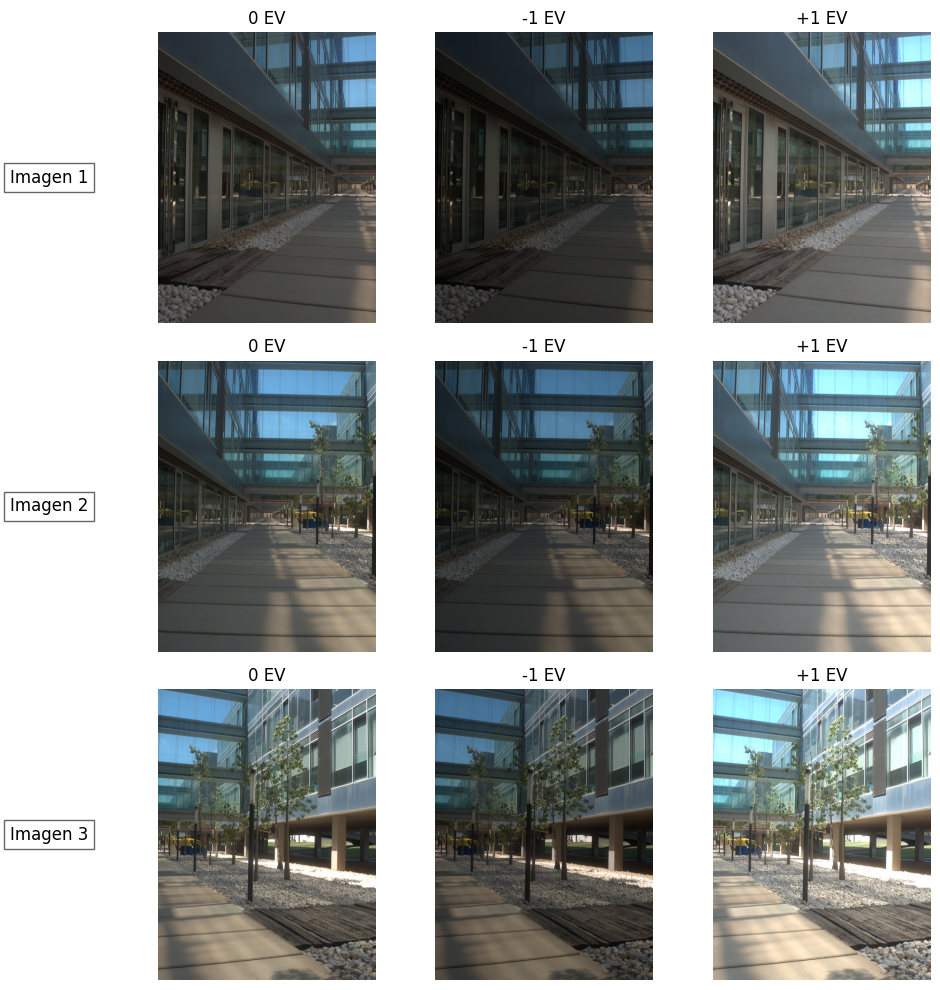

In [2]:
# Redirigir las advertencias a un archivo
log_file = open('warnings.log', 'w')
sys.stderr = log_file

# Cargamos las imágenes
image_paths = glob.glob('RAWimages/*.ORF') #lee ruta de archivos
image_paths.sort(reverse=False) # Solo para MacOs

# Listas para almacenar las imágenes convertidas y los tiempos de exposición
images_8bit = []
time_expos = []

# Cantidad de filas y columnas para las subplots
num_cols = 3
num_rows = len(image_paths) // num_cols + (1 if len(image_paths) % num_cols != 0 else 0)

# Títulos para cada imagen
titles = ["0 EV", "-1 EV", "+1 EV"]

plt.figure(figsize=(10, 10))

# Función para obtener el tiempo de exposición de una imagen RAW
def obtener_time_expo(ruta):
  with open(ruta, 'rb') as f:
      tags = exifread.process_file(f)
      tiempo_exposicion = tags['EXIF ExposureTime']
      return float(tiempo_exposicion.values[0].num) / float(tiempo_exposicion.values[0].den)

# Para cada imagen RAW
for i, image in enumerate(image_paths):
  # Leer y procesar la imagen RAW
  raw = rawpy.imread(image)
  image_8bit = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=8)
  images_8bit.append(image_8bit) 

  # Obtener el tiempo de exposición
  time_expo = obtener_time_expo(image)
  time_expos.append(time_expo)
  
  # Calcular la posición en la cuadrícula
  row = i // num_cols
  col = i % num_cols

  # Mostrar las imágenes en su correspondiente subplot
  plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(image_8bit)
  plt.title(titles[col])
  plt.axis('off')

  # Agregar el texto a la izquierda de la primera imagen de cada fila
  if col == 0:
    plt.gca().annotate('Imagen {0}'.format(row + 1),
                        xy=(-0.5, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()

### 2. Procesado y guardado de las imágenes HDR
Existen diversos métodos de procesado de imágenes HDR. En esta ocasión veremos el método 'Debevec', que se trata de una técnica de fusión HDR utilizando la respuesta de la cámara y la función de mapeo de tonos. 
Para ello seguiremos los siguientes pasos:
* Cargamos las imágenes RAW de nuestro equipo.
* Combinamos las tres imágenes normalizadas en una sola imagen HDR. Este proceso fusiona las imágenes para aprovechar las mejores partes de cada una, reduciendo las áreas sobreexpuestas o subexpuestas.
* Aplicamos un tone mapping para ajustar el rango dinámico a un formato que se pueda visualizar. Esto ajusta los valores de luminancia para que puedan ser representados en una imagen de 8 bits.
* Finalmente la imagen HDR mapeada se guarda como un archivo JPG. 

Este proceso se repite para cada grupo de tres imágenes, resultando en tres imágenes HDR finales.

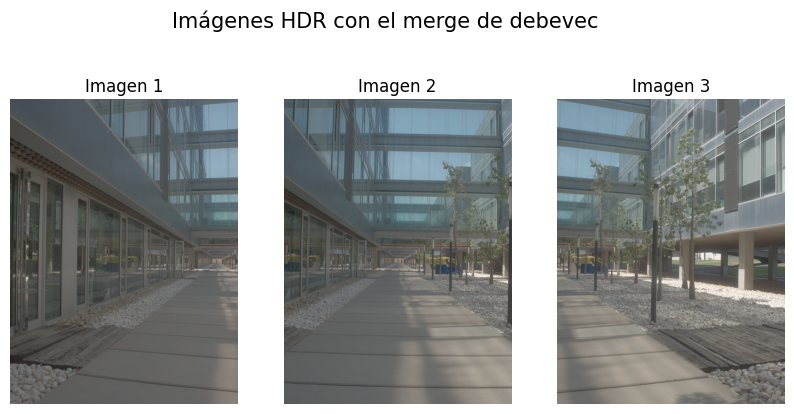

In [3]:
#Exposiciones para las imágenes (s)
t_expo = []

# Dividimos time_expos en grupos de tres y los agregamos como sub-listas en t_expo
for i in range(0, len(time_expos), 3):
    t_expo.append(time_expos[i:i+3])

# Convertimos t_expo en un array numpy
t_expo = np.array(t_expo, dtype=np.float32)

#Creamos una figura para mostrar las imágenes resultantes
plt.figure(figsize=(10, 5))
plt.suptitle('Imágenes HDR con el merge de debevec', fontsize=15)

j=0

#Iteramos a través de las imágenes de 8 bits en grupos de 3
for i in range(0, len(images_8bit), 3):
    images = [images_8bit[i], images_8bit[i+1], images_8bit[i+2]]
    # Seleccionamos la lista de tiempos de exposición correspondiente al grupo actual
    t_exp_group = t_expo[j]

    #Usamos merge_debevec para fusionar y crear una imagen HDR
    merge_debevec = cv2.createMergeDebevec()
    hdr = merge_debevec.process(images, times=t_exp_group)

    #Tonemapping
    tonemap1 = cv2.createTonemap(gamma=2.2)
    tonemap_img = tonemap1.process(hdr.copy())

    #Pasamos a 8 bits y guardamos
    hdr_image_8bit = np.clip(tonemap_img*255, 0, 255).astype('uint8')
    plt.imsave('images/imagenHDR{0}.jpg'.format(j), hdr_image_8bit)

    # Mostramos las imágenes HDR finales
    plt.subplot(1, len(images_8bit)//3, j+1)
    plt.imshow(hdr_image_8bit)
    plt.title("Imagen {0}".format(j+1))
    plt.axis('off')

    j += 1

### 3. Procesado y guardado de las imágenes HDR con otro método de merge (Mertens fusion)
Como hemos mencionado existen varias formas de obtener imágenes HDR. El método Mertens es otra de ellas, y se basa en la fusión de exposición que no requiere conocer o calcular la curva de respuesta de la cámara.

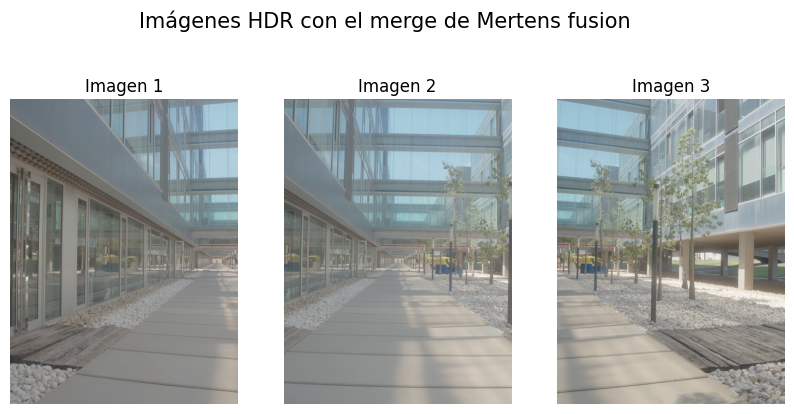

In [4]:
plt.figure(figsize=(10, 5))
plt.suptitle('Imágenes HDR con el merge de Mertens fusion', fontsize=15)

j=0

for i in range(0, len(images_8bit), 3):
    images = [images_8bit[i], images_8bit[i+1], images_8bit[i+2]]
    merge_mertens = cv2.createMergeMertens()
    hdr = merge_mertens.process(images)

    #Tonemapping
    tonemap1 = cv2.createTonemap(gamma=2.2)
    tonemap_img = tonemap1.process(hdr.copy())

    #Pasamos a 8 bits y guardamos
    hdr_image_8bit = np.clip(tonemap_img*255, 0, 255).astype('uint8')
    plt.imsave('images/mertens/imagenHDR{0}.jpg'.format(j), hdr_image_8bit)

    plt.subplot(1, 3, j+1)
    plt.imshow(hdr_image_8bit)
    plt.title("Imagen {0}".format(j+1))
    plt.axis('off')

    j += 1

### Mertens o Debevec
El algoritmo de Debevec es más fiel a lo que físicamente sería un alto rango dinámico. Este usa la curva de respuesta propia de la cámara y requiere conocer los tiempos de exposición de cada foto. Debido a esto produce imágenes HDR muy precisas, aunque no tan llamativas.
Por otro lado, el algoritmo de Mertens es más simple, pues no tiene en cuenta la curva de respuesta. En consecuencia no es demasiado realista, pero produce imágenes más vistosas, con más contraste y colores más saturados.
En resumen, ambos métodos tienen sus propias aplicaciones y ventajas, elegir uno u otro dependerá de las necesidades especifícas de cada uno.


---
# Panorámica
Una panorámica es una técnica fotográfica que captura un campo de visión amplio mediante la toma y unión de múltiples fotografías consecutivas, creando una imagen continua y expansiva. El proceso para unir estas imágenes se denomina stitching. 

Este proceso tiene varios pasos: adquisición de imágenes superpuestas, detección de características distintivas en cada imagen (como esquinas o texturas), emparejamiento de estas características entre imágenes adyacentes, estimación de la transformación (homografía) necesaria para alinear las imágenes, aplicación de dicha transformación para ajustar las imágenes y finalmente, la mezcla y fusión de las imágenes para lograr una transición suave y continua.

### 1. Cargamos las imágenes

El primer paso para crear nuestra panorámica será cargar las imágenes que queremos utilizar. Estas se encuentran dentro de la carpeta images en el mismo directorio que este cuaderno. Utilizaremos glob para leer la ruta, luego usaremos OpenCV para leerlas y pasarlas a RGB (ya que vamos a representarlas usando matplotlib) y por último añadiremos las imágenes a una lista.

Después, representaremos las imágenes que vamos a utilizar mediante matplotlib.

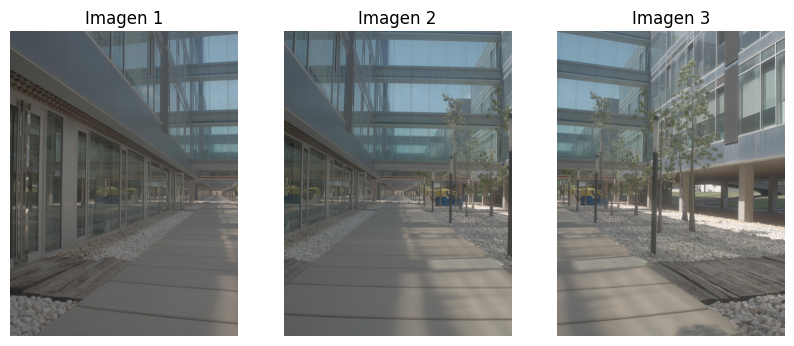

In [5]:
#Cargamos las imágenes
image_paths = glob.glob('images/*.jpg') #lee ruta de archivos
images = []

for image in image_paths:
    img = cv2.imread(image, cv2.IMREAD_COLOR) #lee la imagen
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #pasa a RGB
    images.append(img_rgb) #añade a la lista

#Mostramos las imágenes originales
plt.figure(figsize=(10, 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.title("Imagen {0}".format(i+1))
    plt.axis('off')

### 2. Image Stitching

Comenzamos juntando nuestras imágenes creando un objeto Stitcher de OpenCV mediante el método `cv2.createStitcher()` (para OpenCV 3) o `cv2.Stitcher_create()` (para OpenCV 4). Luego usaremos este objeto para unir las imágenes utilizando el método `stitch()`. Este método toma un parámetro de entrada (las imágenes que queremos unir) y devuelve dos parámetros de salida: la imagen panorámica creada y la variable `status`, que indica si el proceso de stitching ha sido exitoso o no.

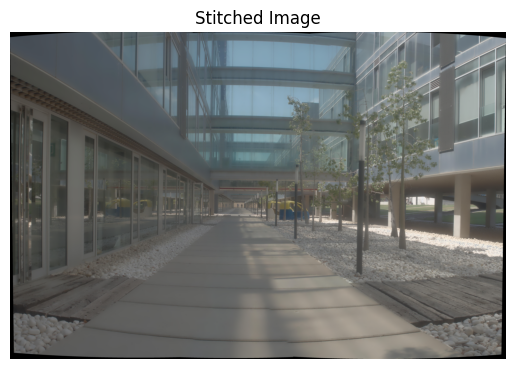

In [6]:
# Inicializamos el objeto image stitcher y luego hacemos el image stitching
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

# si el status es '0', OpenCV realizó con éxito el stitching
if status == 0:
    # guardamos la imagen panoramica
    # mostramos la imagen unida
    plt.imshow(stitched)
    plt.title("Stitched Image")
    plt.axis('off');

# si el stitching falló imprimimos el mensaje de error
else:
	print("[INFO] image stitching failed ({})".format(status))

### 3. Recortar el área de interés

Para crear una imagen panorámica más bonita, vamos a recortarla de manera que solo se vea la parte de interés de la imagen. Para ello, haremos lo siguiente:
* Crear un borde alrededor de la imagen unida.
* Pasar la imagen a escala de grises.
* Crear un umbral que separe la imagen (píxeles de valor mayor que 0) de la parte negra (píxeles de valor igual a 0).

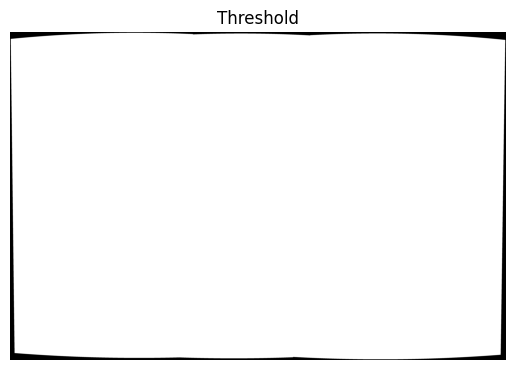

In [7]:
#creamos un borde de 10px alrededor de la imagen
stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))

#convertimos la imagen a escala de grises y crear el umbral
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#muestra la imagen umbralizada
plt.imshow(thresh, cmap="gray")
plt.title("Threshold")
plt.axis('off');

Ahora tenemos una imagen binaria donde los píxeles blancos (255) son el primer plano (nuestra imagen) y los píxeles negros (0) son el fondo.

Usando nuestra imagen umbralizada podemos aplicar extracción de contornos, calcular el cuadro delimitador del contorno más grande (el contorno de la panorámica) y dibujar el cuadro delimitador.

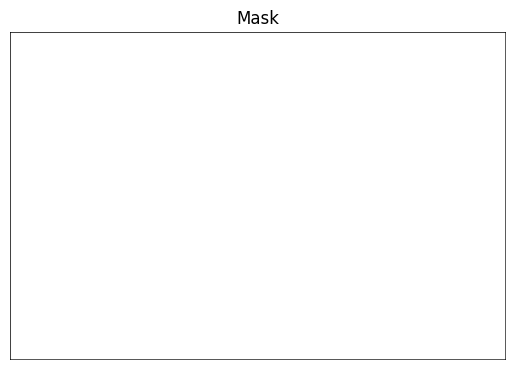

In [8]:
#extraemos los contornos de la imagen umbralizada
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# encuentra el contorno mas grande, que sera el de la imagen panoramica
c = max(cnts, key=cv2.contourArea)

# crea la mascara que contendra la caja delimitadora de la region de la imagen panoramica
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# muestra la mascara
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off');

Este cuadro delimitador es la región rectangular más pequeña en la que puede caber toda la panorámica.

Ahora, crearemos dos copias de la máscara. Una (`minRect`) se reducirá en tamaño poco a poco hasta que quepa en la parte interior de la panorámica. La otra (`sub`), se usará para determinar si necesitamos seguir reduciendo el tamaño de `minRect`.

Haremos lo siguiente:
* Crear un bucle que se ejecute hasta que no haya píxeles distintos de 0 (primer plano) en `sub`.
* Erosionar `minRect` para reducir su tamaño.
* Sustraer `thresh` (la imagen umbralizada) de `minRect`, y asignar la imagen resultante a la variable `sub`.

De este modo, iremos reduciendo el tamaño de `minRect` hasta que no queden píxeles de primer plano en `sub`. En estte punto habremos encontrado la máscara rectangular más pequeña que cabe dentro de la región rectangular más grande de la panorámica.

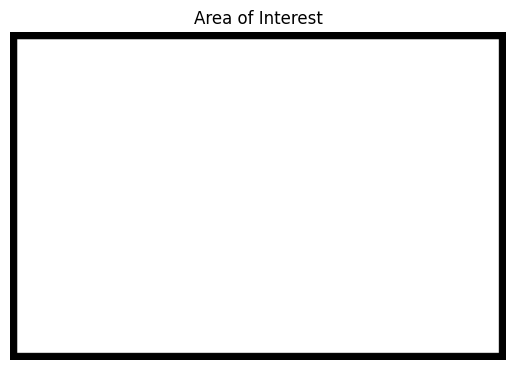

In [9]:
# crea 2 copias de la mascara
minRect = mask.copy() # minimum rectangular region
sub = mask.copy() # cuantos px debemos eliminar de minRect

# bucle hasta que no hayan píxeles distintos de 0 en sub
while cv2.countNonZero(sub) > 0:
    minRect = cv2.erode(minRect, None) # erosiona minRect
    sub = cv2.subtract(minRect, thresh) # resta minRect y thresh: saber si quedan px distintos de 0

# representa el área de interés
plt.imshow(minRect, cmap="gray")
plt.title("Area of Interest")
plt.axis('off');

Por último, usando el mínimo rectángulo podemos extraer de nuevos los contornos y crear la caja delimitadora:

* Extraer los contornos de `minRect`.
* Coger el contorno más grande.
* Crear la caja delimitadora del contorno más grande.
* Extraer el área de interés de la panorámica usando la información de la caja delimitadora.

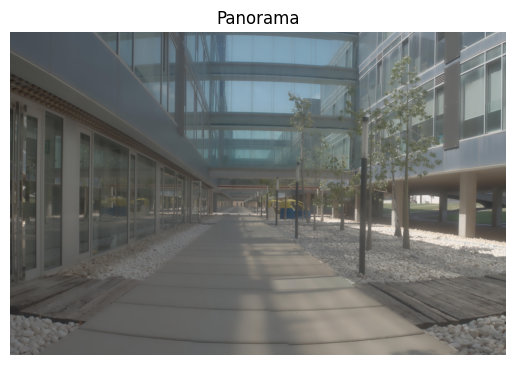

In [10]:
# encuentra contornos en la mascara rectangular minima
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# extrae las coordenadas (x, y) de la caja delimitadora
(x, y, w, h) = cv2.boundingRect(c)

# usa las coordenadas de la caja para extraer el área de interés de la imagen
stitched = stitched[y:y + h, x:x + w]

# guarda la imagen 
plt.imsave("panoramicas/panorama.jpg", stitched)

#representa la imagen
plt.imshow(stitched)
plt.title("Panorama")
plt.axis('off');

---
# Comparativa de panorámicas

In [11]:
from funciones import *
path = 'images/mertens/*'
panorama(path,"Panorama Mertens")

path_sin = 'images/sin_HDR/*'
panorama(path_sin,"Panorama Sin HDR")

[INFO] stitching images...
[INFO] cropping...
[INFO] saving...
[INFO] stitching images...
[INFO] cropping...
[INFO] saving...


### Panorámica sin HDR vs HDR(Debevec) vs HDR(Mertens)

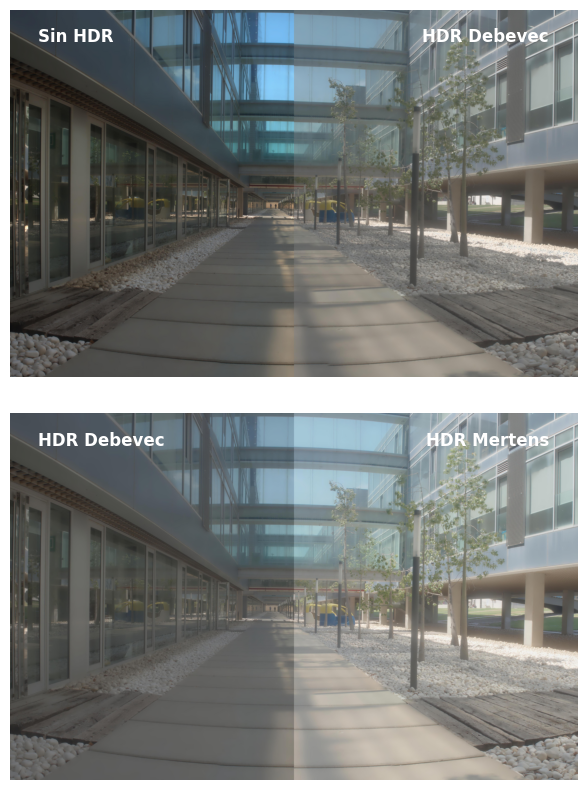

In [12]:
# Cargamos las imágenes
image_paths = glob.glob('panoramicas/*.jpg') #lee ruta de archivos
images = []
image_paths.sort(reverse=False) # Solo para MacOs

for image in image_paths:
    img = cv2.imread(image, cv2.IMREAD_COLOR) #lee la imagen
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #pasa a RGB
    images.append(img_rgb) #añade a la lista

# Obtenemos las dimensiones
dimensiones = [img.shape[:2] for img in images]

# Verificar si todas las dimensiones son iguales
if not all(dim == dimensiones[0] for dim in dimensiones):
    # Si no son iguales, ajustar todas las imágenes al tamaño mínimo común
    min_height = min(dim[0] for dim in dimensiones)
    min_width = min(dim[1] for dim in dimensiones)
    for i in range(len(images)):
        images[i] = cv2.resize(images[i], (min_width, min_height))

# Función para recortar una imagen por la mitad
def recortar_mitad(image):
    height, width, _ = image.shape
    mitad_ancho = width // 2
    imagen_izquierda = image[:, :mitad_ancho]
    imagen_derecha = image[:, mitad_ancho:]
    return imagen_izquierda, imagen_derecha

# Recortar ambas imágenes por la mitad
img_izq_1, img_dch_1 = recortar_mitad(images[0])
img_izq_2, img_dch_2 = recortar_mitad(images[1]) 
img_izq_3, img_dch_3 = recortar_mitad(images[2]) 

# Concatenar las mitades izquierdas y derechas para formar la nueva imagen combinada
sin_con_HDR = cv2.hconcat([img_izq_3, img_dch_1])
HDR_con_Mertens = cv2.hconcat([img_izq_1, img_dch_2])

# Función para agregar texto en las esquinas
def txt_esquina(text1, text2):
    plt.text(0.05, 0.95, text1, color='white', fontsize=12, fontweight='bold', ha='left', va='top', transform=plt.gca().transAxes)
    plt.text(0.95, 0.95, text2, color='white', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

# Mostrar las imágenes combinadas
plt.figure(figsize=(15, 10))

# Representar la imagen combinadada Sin_HDR
plt.subplot(211)
plt.imshow(sin_con_HDR)
txt_esquina('Sin HDR', 'HDR Debevec')
plt.axis('off')

# Representar la imagen combinadada HDR_con_Martens
plt.subplot(212)
plt.imshow(HDR_con_Mertens)
txt_esquina('HDR Debevec', 'HDR Mertens')
plt.axis('off')

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()